<a href="https://colab.research.google.com/github/kevin-pooler/AA1-501-Team5-Final/blob/main/ViT_Gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install vit-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadat

# Training and Testing helpers

In [ ]:
def eval(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            # Get the inputs
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = net(images)
            probabilities = torch.sigmoid(outputs)

            # Compare predicted with ground truth
            predicted = (probabilities >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
import torch
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(net, criterion, optimizer, trainloader, testloader, epochs=10, gradient_clipping=None, scheduler=None, quiet=False, output_file='vit'):
  start_time = time.time()
  accuracies = []
  max_accuracy = 0
  for epoch in range(epochs):
      current_lr = optimizer.param_groups[0]['lr']
      if not quiet:
        print(f'Epoch {epoch + 1}/{epochs} - Current Learning Rate: {current_lr:.6f}')
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # Get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          # Backward pass and optimize
          loss.backward()
          if gradient_clipping is not None:
            torch.nn.utils.clip_grad_norm_(net.parameters(), gradient_clipping)
          optimizer.step()

          # Print statistics
          running_loss += loss.item()

          report_frequency = len(trainloader) // 5
          if i % report_frequency == 0:    # Print every 200 mini-batches
              if not quiet:
                print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] loss: {running_loss / report_frequency:.3f}')
              running_loss = 0.0

      # Handle learning rate scheduler, if needed
      if scheduler is not None:
        scheduler.step()

      # Run evaluation on test set and train set
      train_acc = eval(net, trainloader)
      test_acc = eval(net, testloader)
      accuracies.append((train_acc, test_acc))
      if not quiet:
          print(f'Accuracy of the network on the test images: {100 * test_acc:.2f}%')

      if test_acc > max_accuracy:
          max_accuracy = test_acc
          # Save the trained model
          PATH = f'./{output_file}_{float(test_acc):.2f}.pth'
          torch.save(net.state_dict(), PATH)


  end_time = time.time()
  if not quiet:
    print(f'Finished Training, took {(end_time - start_time):.2f} seconds')

  final_acc = eval(net, testloader)
  return accuracies

# Prepare Dataset

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import RandomErasing, RandomHorizontalFlip
from sklearn.model_selection import KFold

# Load and preprocess the CSV file
data = pd.read_csv('age_gender.csv')
data['pixels'] = data['pixels'].apply(lambda x: list(map(int, x.strip('[]').split(' '))))

# Define the custom dataset
class FaceGenderDataset(Dataset):
    def __init__(self, dataframe, transform=None, filter_by_age=None):
        if filter_by_age is None:
            self.dataframe = dataframe
        else:
            self.dataframe = dataframe[dataframe['age'] > filter_by_age]
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['pixels']
        label = self.dataframe.iloc[idx]['gender']
        image = np.array(image, dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(image, mode='L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label).unsqueeze(0).float()
        return image, label

# Split the data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=452)

# Split the data for cross validation
kf_idx = list(KFold(n_splits=5, shuffle=True, random_state=452).split(data))

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    RandomHorizontalFlip(p=0.5),
    RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3), inplace=False),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
])

# Create DataLoader for train and test sets
train_dataset = FaceGenderDataset(train_df, transform=transform_train)
test_dataset = FaceGenderDataset(test_df, transform=transform_test)

BATCH_SIZE = 512
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

kf_loaders = [
    (DataLoader(FaceGenderDataset(data.iloc[train_idx], transform=transform_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    DataLoader(FaceGenderDataset(data.iloc[test_idx], transform=transform_test), batch_size=64, shuffle=False, num_workers=2))
    for (train_idx, test_idx) in kf_idx
]

# Ablation Study

In [ ]:
from vit_pytorch.vit import ViT
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

BEST_PARAMETERS = {
    # Dataset-dependant parameters
    'image_size': 48,
    'channels': 1,
    'num_classes': 1,
    # Parameters we can play with
    'patch_size': 8,
    'dim': 256,
    'depth': 6,
    'heads': 16,
    'mlp_dim': 512,
    'dropout': 0.1,
    'emb_dropout': 0.1,
}

BASE_PARAMETERS = {
  # Dataset-dependant parameters
  'image_size': 48,
  'channels': 1,
  'num_classes': 1,
  # Parameters we can play with
  'patch_size': 16,
  'dim': 512,
  'depth': 6,
  'heads': 16,
  'mlp_dim': 1024,
  'dropout': 0.1,
  'emb_dropout': 0.1,
}

def ablation_train(model_parameters, epochs=5, base_parameters=BASE_PARAMETERS):


  final_parameters = base_parameters.copy()
  final_parameters.update(model_parameters)

  net = ViT(**final_parameters).to(device)

  EPOCHS = 5
  LR = 0.0005 * BATCH_SIZE / 512

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)
  scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

  accuracies = train(net, criterion, optimizer, trainloader, testloader, epochs=EPOCHS, scheduler=scheduler, quiet=True)
  test_accuracies = np.array(accuracies)[:, 1]
  max_accuracy = np.max(test_accuracies)

  del net

  return max_accuracy

In [ ]:
def run_ablation_study_single_parameter(ablation_parameters):
    results = {}

    for param, values in ablation_parameters.items():
        results[param] = {}
        for value in values:
            try:
                # Create a dictionary with the current parameter and value
                model_parameters = {param: value}
                # Run the ablation_train function with these parameters
                print(f'Training with {model_parameters}')
                max_accuracy = ablation_train(model_parameters)
            except Exception as e:
                # If an error occurs, set max_accuracy to 0
                max_accuracy = 0
                print(f"!!! Error with {param}={value}: {e} !!!")
            # Store the result
            results[param][value] = max_accuracy
            #print(results)

    return results

In [ ]:
ablation_parameters = {
    'patch_size': [4, 8, 16, 32],
    'dim': [128, 256, 512, 1024],
    'depth': [4, 6, 8],
    'heads': [8, 12, 16, 20],
    'mlp_dim': [512, 1024, 2048],
    'dropout': [0.0, 0.1, 0.2],
    'emb_dropout': [0.0, 0.1, 0.2],
}

ablation_study_results = run_ablation_study_single_parameter(ablation_parameters)
print(ablation_study_results)

Training with {'patch_size': 4}
{'patch_size': {4: 0.797721999578148}}
Training with {'patch_size': 8}
{'patch_size': {4: 0.797721999578148, 8: 0.8278844125711875}}
Training with {'patch_size': 16}
{'patch_size': {4: 0.797721999578148, 8: 0.8278844125711875, 16: 0.8453912676650496}}
Training with {'patch_size': 32}
!!! Error with patch_size=32: Image dimensions must be divisible by the patch size. !!!
{'patch_size': {4: 0.797721999578148, 8: 0.8278844125711875, 16: 0.8453912676650496, 32: 0}}
Training with {'dim': 128}
{'patch_size': {4: 0.797721999578148, 8: 0.8278844125711875, 16: 0.8453912676650496, 32: 0}, 'dim': {128: 0.8730225690782535}}
Training with {'dim': 256}
{'patch_size': {4: 0.797721999578148, 8: 0.8278844125711875, 16: 0.8453912676650496, 32: 0}, 'dim': {128: 0.8730225690782535, 256: 0.8519299725796246}}
Training with {'dim': 512}
{'patch_size': {4: 0.797721999578148, 8: 0.8278844125711875, 16: 0.8453912676650496, 32: 0}, 'dim': {128: 0.8730225690782535, 256: 0.851929972

In [ ]:
from itertools import product

def run_ablation_study_permute_parameters(base_ablation_parameters, epochs, base_parameters):
    results = {}
    # Get all parameter names and their corresponding values
    param_names = list(base_ablation_parameters.keys())
    param_values = list(base_ablation_parameters.values())

    # Iterate over all possible combinations of parameter values
    for ablation_parameters in product(*param_values):
        # Create a dictionary for the current combination of parameter values
        model_parameters = dict(zip(param_names, ablation_parameters))
        try:
            # Print current configuration
            print(f'Training with {model_parameters}')
            # Run the ablation_train function with these parameters
            max_accuracy = ablation_train(model_parameters, epochs=epochs, base_parameters=base_parameters)
        except Exception as e:
            # If an error occurs, set max_accuracy to 0
            max_accuracy = 0
            print(f"!!! Error with {model_parameters}: {e} !!!")
        # Store the result
        results[tuple(model_parameters.items())] = max_accuracy
        print(results)

    return results

In [ ]:
base_parameters = {
  # Dataset-dependant parameters
  'image_size': 48,
  'channels': 1,
  'num_classes': 1,
  # Parameters we fixed
  'depth': 8,
  'heads': 16,
  'dropout': 0.0,
  'emb_dropout': 0.0,
  # Parameters we are going to keep playing with
  'patch_size': 16,
  'dim': 128,
  'mlp_dim': 2048,
}

base_ablation_parameters = {
    'patch_size': [8, 16],
    'dim': [128, 256],
    'mlp_dim': [512, 2048],
}

results = run_ablation_study_permute_parameters(base_ablation_parameters, 1, base_parameters)
print(results)

# Train

In [ ]:
# Original ViT
import torch
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from vit_pytorch.vit import ViT

accuracies = []
for fold_i, (trainloader, testloader) in enumerate(kf_loaders):
  print(f' ===== Fold {fold_i} =====')
  if fold_i in (0, 1): # Skip already trained folds
    continue
  net = ViT(
      image_size = 48,
      patch_size = 8,
      num_classes = 1,
      dim = 128,
      depth = 8,
      heads = 16,
      mlp_dim = 512,
      dropout = 0.0,
      emb_dropout = 0.0,
      channels = 1
  ).to(device)

  EPOCHS = 30
  LR = 0.0005 * BATCH_SIZE / 512

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)
  scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

  fold_acc = train(net, criterion, optimizer, trainloader, testloader, epochs=EPOCHS, scheduler=scheduler, output_file=f'vit-{fold_i}')
  print(fold_acc)
  accuracies.append(fold_acc)

print(accuracies)

 ===== Fold 0 =====
Epoch 1/30 - Current Learning Rate: 0.001000
[Epoch: 1, Batch: 1] loss: 0.100
[Epoch: 1, Batch: 8] loss: 1.034
[Epoch: 1, Batch: 15] loss: 0.702
[Epoch: 1, Batch: 22] loss: 0.696
[Epoch: 1, Batch: 29] loss: 0.686
[Epoch: 1, Batch: 36] loss: 0.669
Accuracy of the network on the test images: 70.66%
Epoch 2/30 - Current Learning Rate: 0.000997
[Epoch: 2, Batch: 1] loss: 0.090
[Epoch: 2, Batch: 8] loss: 0.581
[Epoch: 2, Batch: 15] loss: 0.498
[Epoch: 2, Batch: 22] loss: 0.438
[Epoch: 2, Batch: 29] loss: 0.434
[Epoch: 2, Batch: 36] loss: 0.415
Accuracy of the network on the test images: 75.03%
Epoch 3/30 - Current Learning Rate: 0.000989
[Epoch: 3, Batch: 1] loss: 0.085
[Epoch: 3, Batch: 8] loss: 0.434
[Epoch: 3, Batch: 15] loss: 0.403
[Epoch: 3, Batch: 22] loss: 0.403
[Epoch: 3, Batch: 29] loss: 0.379
[Epoch: 3, Batch: 36] loss: 0.368
Accuracy of the network on the test images: 84.62%
Epoch 4/30 - Current Learning Rate: 0.000976
[Epoch: 4, Batch: 1] loss: 0.049
[Epoch: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the test images: 89.31%
Epoch 24/30 - Current Learning Rate: 0.000128
[Epoch: 24, Batch: 1] loss: 0.018
[Epoch: 24, Batch: 8] loss: 0.112
[Epoch: 24, Batch: 15] loss: 0.136
[Epoch: 24, Batch: 22] loss: 0.119
[Epoch: 24, Batch: 29] loss: 0.114


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>AssertionError
: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: if w.is_aliv

[Epoch: 24, Batch: 36] loss: 0.107


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the test images: 89.33%
Epoch 25/30 - Current Learning Rate: 0.000095
[Epoch: 25, Batch: 1] loss: 0.015
[Epoch: 25, Batch: 8] loss: 0.110
[Epoch: 25, Batch: 15] loss: 0.112
[Epoch: 25, Batch: 22] loss: 0.093
[Epoch: 25, Batch: 29] loss: 0.115


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 25, Batch: 36] loss: 0.112


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the test images: 89.31%
Epoch 26/30 - Current Learning Rate: 0.000067
[Epoch: 26, Batch: 1] loss: 0.025
[Epoch: 26, Batch: 8] loss: 0.103
[Epoch: 26, Batch: 15] loss: 0.108
[Epoch: 26, Batch: 22] loss: 0.108
[Epoch: 26, Batch: 29] loss: 0.107
[Epoch: 26, Batch: 36] loss: 0.099
Accuracy of the network on the test images: 89.31%
Epoch 27/30 - Current Learning Rate: 0.000043
[Epoch: 27, Batch: 1] loss: 0.013
[Epoch: 27, Batch: 8] loss: 0.089
[Epoch: 27, Batch: 15] loss: 0.104
[Epoch: 27, Batch: 22] loss: 0.099
[Epoch: 27, Batch: 29] loss: 0.094
[Epoch: 27, Batch: 36] loss: 0.115
Accuracy of the network on the test images: 89.12%
Epoch 28/30 - Current Learning Rate: 0.000024
[Epoch: 28, Batch: 1] loss: 0.010
[Epoch: 28, Batch: 8] loss: 0.087
[Epoch: 28, Batch: 15] loss: 0.087
[Epoch: 28, Batch: 22] loss: 0.107
[Epoch: 28, Batch: 29] loss: 0.103


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 28, Batch: 36] loss: 0.105


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

Accuracy of the network on the test images: 89.47%
Epoch 29/30 - Current Learning Rate: 0.000011
[Epoch: 29, Batch: 1] loss: 0.019
[Epoch: 29, Batch: 8] loss: 0.094
[Epoch: 29, Batch: 15] loss: 0.092
[Epoch: 29, Batch: 22] loss: 0.093
[Epoch: 29, Batch: 29] loss: 0.109


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 29, Batch: 36] loss: 0.086


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    can only test a child process
self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Accuracy of the network on the test images: 89.33%
Epoch 30/30 - Current Learning Rate: 0.000003
[Epoch: 30, Batch: 1] loss: 0.010
[Epoch: 30, Batch: 8] loss: 0.091
[Epoch: 30, Batch: 15] loss: 0.096
[Epoch: 30, Batch: 22] loss: 0.102
[Epoch: 30, Batch: 29] loss: 0.096


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 30, Batch: 36] loss: 0.095
Accuracy of the network on the test images: 89.35%
Finished Training, took 1021.03 seconds
[(0.7079730014764818, 0.7066019827040708), (0.7327568023623708, 0.7502636574562329), (0.8363741826618857, 0.8462349715249947), (0.8588905294241721, 0.8654292343387471), (0.8105357519510652, 0.8156507066019827), (0.8747099767981439, 0.870491457498418), (0.8728643746045138, 0.8742881248681713), (0.8840434507487872, 0.8789284960978696), (0.8853090065387049, 0.8713351613583632), (0.8940097025943894, 0.878506644167897), (0.874077198903185, 0.8628981227589116), (0.8898439147859102, 0.8782957182029107), (0.9120438726007172, 0.8858890529424173), (0.9223792448850453, 0.8896857203121704), (0.9001792870702383, 0.8711242353933769), (0.9277051255009492, 0.888631090487239), (0.9367222105041131, 0.888631090487239), (0.9415207762075511, 0.8911622020670744), (0.9468466568234549, 0.8941151655768825), (0.9440518877873866, 0.8913731280320607), (0.9524361948955916, 0.896646277156718

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored

[Epoch: 1, Batch: 15] loss: 0.693
[Epoch: 1, Batch: 22] loss: 0.688
[Epoch: 1, Batch: 29] loss: 0.673
[Epoch: 1, Batch: 36] loss: 0.656


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    : can only test a child process
Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/pyth

Accuracy of the network on the test images: 73.23%
Epoch 2/30 - Current Learning Rate: 0.000997
[Epoch: 2, Batch: 1] loss: 0.087
[Epoch: 2, Batch: 8] loss: 0.596


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/pyt

[Epoch: 2, Batch: 15] loss: 0.564
[Epoch: 2, Batch: 22] loss: 0.535
[Epoch: 2, Batch: 29] loss: 0.469
[Epoch: 2, Batch: 36] loss: 0.451


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the test images: 75.55%
Epoch 3/30 - Current Learning Rate: 0.000989
[Epoch: 3, Batch: 1] loss: 0.071
[Epoch: 3, Batch: 8] loss: 0.459


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

[Epoch: 3, Batch: 15] loss: 0.420
[Epoch: 3, Batch: 22] loss: 0.397
[Epoch: 3, Batch: 29] loss: 0.383
[Epoch: 3, Batch: 36] loss: 0.376


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Accuracy of the network on the test images: 83.17%
Epoch 4/30 - Current Learning Rate: 0.000976
[Epoch: 4, Batch: 1] loss: 0.053
[Epoch: 4, Batch: 8] loss: 0.372


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 4, Batch: 15] loss: 0.362
[Epoch: 4, Batch: 22] loss: 0.343
[Epoch: 4, Batch: 29] loss: 0.320
[Epoch: 4, Batch: 36] loss: 0.316


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tor

Accuracy of the network on the test images: 80.19%
Epoch 5/30 - Current Learning Rate: 0.000957
[Epoch: 5, Batch: 1] loss: 0.062
[Epoch: 5, Batch: 8] loss: 0.399


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 5, Batch: 15] loss: 0.374
[Epoch: 5, Batch: 22] loss: 0.338
[Epoch: 5, Batch: 29] loss: 0.331
[Epoch: 5, Batch: 36] loss: 0.331


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
: can only test a child process
    if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the test images: 84.22%
Epoch 6/30 - Current Learning Rate: 0.000933
[Epoch: 6, Batch: 1] loss: 0.053
[Epoch: 6, Batch: 8] loss: 0.343


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_aliv

[Epoch: 6, Batch: 15] loss: 0.334
[Epoch: 6, Batch: 22] loss: 0.329
[Epoch: 6, Batch: 29] loss: 0.306
[Epoch: 6, Batch: 36] loss: 0.302


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/pyt

Accuracy of the network on the test images: 86.08%
Epoch 7/30 - Current Learning Rate: 0.000905
[Epoch: 7, Batch: 1] loss: 0.043


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

AssertionError    : self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: if w.is_aliv

[Epoch: 7, Batch: 8] loss: 0.348
[Epoch: 7, Batch: 15] loss: 0.313
[Epoch: 7, Batch: 22] loss: 0.322
[Epoch: 7, Batch: 29] loss: 0.296
[Epoch: 7, Batch: 36] loss: 0.284


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0><function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/pyt

Accuracy of the network on the test images: 86.71%
Epoch 8/30 - Current Learning Rate: 0.000872
[Epoch: 8, Batch: 1] loss: 0.034


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/

[Epoch: 8, Batch: 8] loss: 0.278
[Epoch: 8, Batch: 15] loss: 0.279
[Epoch: 8, Batch: 22] loss: 0.278
[Epoch: 8, Batch: 29] loss: 0.281
[Epoch: 8, Batch: 36] loss: 0.293


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_aliv

Accuracy of the network on the test images: 86.88%
Epoch 9/30 - Current Learning Rate: 0.000835
[Epoch: 9, Batch: 1] loss: 0.043


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 9, Batch: 8] loss: 0.257
[Epoch: 9, Batch: 15] loss: 0.271
[Epoch: 9, Batch: 22] loss: 0.264
[Epoch: 9, Batch: 29] loss: 0.270
[Epoch: 9, Batch: 36] loss: 0.286


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Accuracy of the network on the test images: 85.80%
Epoch 10/30 - Current Learning Rate: 0.000794
[Epoch: 10, Batch: 1] loss: 0.048


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 10, Batch: 8] loss: 0.259
[Epoch: 10, Batch: 15] loss: 0.252
[Epoch: 10, Batch: 22] loss: 0.257
[Epoch: 10, Batch: 29] loss: 0.240
[Epoch: 10, Batch: 36] loss: 0.254


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
: can only test a child process    
if w.is_alive():
  File "/usr/lib/

Accuracy of the network on the test images: 87.60%
Epoch 11/30 - Current Learning Rate: 0.000750
[Epoch: 11, Batch: 1] loss: 0.034


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 11, Batch: 8] loss: 0.250
[Epoch: 11, Batch: 15] loss: 0.238
[Epoch: 11, Batch: 22] loss: 0.259
[Epoch: 11, Batch: 29] loss: 0.262
[Epoch: 11, Batch: 36] loss: 0.250


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
if w.is_alive():      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python

Accuracy of the network on the test images: 83.99%
Epoch 12/30 - Current Learning Rate: 0.000703
[Epoch: 12, Batch: 1] loss: 0.037


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>    assert self._parent_pid == os.getpid(), 'can only test a child process'
: 
AssertionErrorTraceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _Multi

[Epoch: 12, Batch: 8] loss: 0.326
[Epoch: 12, Batch: 15] loss: 0.302
[Epoch: 12, Batch: 22] loss: 0.248
[Epoch: 12, Batch: 29] loss: 0.242
[Epoch: 12, Batch: 36] loss: 0.248


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

AssertionError: can only test a child process    
self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _Multi

Accuracy of the network on the test images: 88.34%
Epoch 13/30 - Current Learning Rate: 0.000655
[Epoch: 13, Batch: 1] loss: 0.036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 13, Batch: 8] loss: 0.233
[Epoch: 13, Batch: 15] loss: 0.228
[Epoch: 13, Batch: 22] loss: 0.229
[Epoch: 13, Batch: 29] loss: 0.228
[Epoch: 13, Batch: 36] loss: 0.228


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _Multi

Accuracy of the network on the test images: 88.69%
Epoch 14/30 - Current Learning Rate: 0.000604
[Epoch: 14, Batch: 1] loss: 0.031


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

[Epoch: 14, Batch: 8] loss: 0.238
[Epoch: 14, Batch: 15] loss: 0.235
[Epoch: 14, Batch: 22] loss: 0.222
[Epoch: 14, Batch: 29] loss: 0.217
[Epoch: 14, Batch: 36] loss: 0.219


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/proce

Accuracy of the network on the test images: 88.34%
Epoch 15/30 - Current Learning Rate: 0.000552
[Epoch: 15, Batch: 1] loss: 0.026


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch: 15, Batch: 8] loss: 0.212
[Epoch: 15, Batch: 15] loss: 0.238
[Epoch: 15, Batch: 22] loss: 0.224
[Epoch: 15, Batch: 29] loss: 0.218
[Epoch: 15, Batch: 36] loss: 0.209


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0><function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/usr/local/lib/python3.10/dist-packages/tor

Accuracy of the network on the test images: 88.40%
Epoch 16/30 - Current Learning Rate: 0.000500
[Epoch: 16, Batch: 1] loss: 0.029


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0><function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError:   File "/usr/lib/python3.10/multiprocessing/pro

[Epoch: 16, Batch: 8] loss: 0.210
[Epoch: 16, Batch: 15] loss: 0.229
[Epoch: 16, Batch: 22] loss: 0.216
[Epoch: 16, Batch: 29] loss: 0.211
[Epoch: 16, Batch: 36] loss: 0.201


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/pyt

Accuracy of the network on the test images: 88.42%
Epoch 17/30 - Current Learning Rate: 0.000448


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

[Epoch: 17, Batch: 1] loss: 0.026
[Epoch: 17, Batch: 8] loss: 0.181
[Epoch: 17, Batch: 15] loss: 0.197
[Epoch: 17, Batch: 22] loss: 0.184
[Epoch: 17, Batch: 29] loss: 0.185
[Epoch: 17, Batch: 36] loss: 0.196


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
AssertionError    : if w.is_alive():can only test a child process

  File "/usr/lib/

Accuracy of the network on the test images: 88.29%
Epoch 18/30 - Current Learning Rate: 0.000396


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():    
self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError:   File "/usr/lib/python3.10/multiprocessing/pro

[Epoch: 18, Batch: 1] loss: 0.023
[Epoch: 18, Batch: 8] loss: 0.178
[Epoch: 18, Batch: 15] loss: 0.178
[Epoch: 18, Batch: 22] loss: 0.173
[Epoch: 18, Batch: 29] loss: 0.194
[Epoch: 18, Batch: 36] loss: 0.158


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799cb07a1ea0>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Accuracy of the network on the test images: 88.88%
Epoch 19/30 - Current Learning Rate: 0.000345
[Epoch: 19, Batch: 1] loss: 0.025
[Epoch: 19, Batch: 8] loss: 0.173
[Epoch: 19, Batch: 15] loss: 0.174
[Epoch: 19, Batch: 22] loss: 0.185
[Epoch: 19, Batch: 29] loss: 0.172
[Epoch: 19, Batch: 36] loss: 0.170
Accuracy of the network on the test images: 88.10%
Epoch 20/30 - Current Learning Rate: 0.000297
[Epoch: 20, Batch: 1] loss: 0.027
[Epoch: 20, Batch: 8] loss: 0.170
[Epoch: 20, Batch: 15] loss: 0.154
[Epoch: 20, Batch: 22] loss: 0.152
[Epoch: 20, Batch: 29] loss: 0.175
[Epoch: 20, Batch: 36] loss: 0.152
Accuracy of the network on the test images: 89.18%
Epoch 21/30 - Current Learning Rate: 0.000250
[Epoch: 21, Batch: 1] loss: 0.020
[Epoch: 21, Batch: 8] loss: 0.162
[Epoch: 21, Batch: 15] loss: 0.150
[Epoch: 21, Batch: 22] loss: 0.151
[Epoch: 21, Batch: 29] loss: 0.143
[Epoch: 21, Batch: 36] loss: 0.150
Accuracy of the network on the test images: 89.22%
Epoch 22/30 - Current Learning Rat

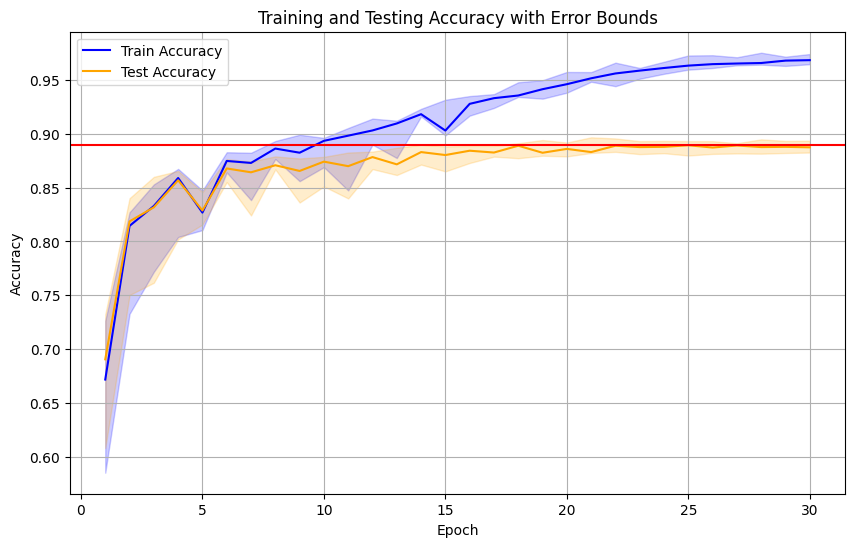

In [ ]:
total_elements = len(data)
false_elements = data[data['prediction_correct'] == False].shape[0]
error_rate = (false_elements / total_elements) * 100

train_accuracies = np.array([[epoch[0] for epoch in model] for model in accuracies])
test_accuracies = np.array([[epoch[1] for epoch in model] for model in accuracies])


train_median = np.median(train_accuracies, axis=0)
train_min = np.min(train_accuracies, axis=0)
train_max = np.max(train_accuracies, axis=0)

test_median = np.median(test_accuracies, axis=0)
test_min = np.min(test_accuracies, axis=0)
test_max = np.max(test_accuracies, axis=0)


epochs = np.arange(1, len(train_median) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_median, label='Train Accuracy', color='blue')
plt.fill_between(epochs, train_min, train_max, color='blue', alpha=0.2)
plt.plot(epochs, test_median, label='Test Accuracy', color='orange')
plt.fill_between(epochs, test_min, test_max, color='orange', alpha=0.2)
plt.axhline(1-error_rate*0.01, color='red')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy with Error Bounds')
plt.legend()
plt.grid(True)
plt.show()


# Results Analysis

In [ ]:
# Load models
import torch
from vit_pytorch.vit import ViT

nets = []
for i in range(5):
  net = ViT(
      image_size = 48,
      patch_size = 8,
      num_classes = 1,
      dim = 128,
      depth = 8,
      heads = 16,
      mlp_dim = 512,
      dropout = 0.0,
      emb_dropout = 0.0,
      channels = 1
  ).to(device)


  model_state_dict = torch.load(f'./vit-{i}.pth', map_location=torch.device(device))
  net.load_state_dict(model_state_dict)

  nets.append(net)

In [ ]:
data['prediction_correct'] = None
data['fold'] = None

for fold_idx, (train_idx, test_idx) in enumerate(kf_idx):
    if fold_idx >= len(nets):
      break
    print(f"Evaluating fold {fold_idx}")
    data.loc[test_idx, 'fold'] = fold_idx
    net = nets[fold_idx]
    net.eval()

    # Create the test DataLoader for the current fold
    test_dataset = FaceGenderDataset(data.iloc[test_idx], transform=transform_test)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize a list to store the correctness of predictions
    results = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            preds = (outputs > 0.5).float()

            corrects = preds.eq(labels.view_as(preds)).cpu().numpy()
            results.extend(corrects)

    # Store the results in the original dataframe
    for idx, correct in zip(test_idx, results):
        data.at[idx, 'prediction_correct'] = bool(correct)


Evaluating fold 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4


In [ ]:
def aggregate_error_by_column(column):
  percentage_error = (
    data[data['prediction_correct'] == False]
    .groupby(['fold', column])
    .size() / data.groupby(['fold', column]).size()
  ) * 100


  percentage_error = percentage_error.reset_index(name='percentage_incorrect')
  return percentage_error.groupby(column)['percentage_incorrect'].agg(['min', 'median', 'max'])


In [ ]:
data['gender'] = data['gender'].replace({0: 'male', 1: 'female'})
data['ethnicity'] = data['ethnicity'].replace({0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'})

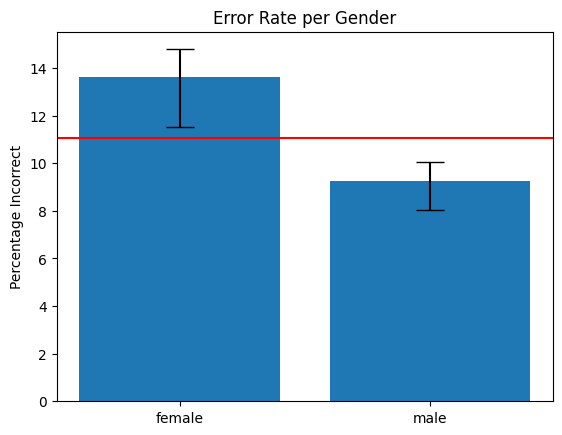

In [ ]:
from matplotlib import pyplot as plt

stats = aggregate_error_by_column('gender')

plt.bar(stats.index, stats['median'], yerr=[stats['median'] - stats['min'], stats['max'] - stats['median']], capsize=10)
plt.axhline(error_rate, color='red')
plt.ylabel('Percentage Incorrect')
plt.xticks(stats.index, stats.index)
plt.title('Error Rate per Gender')
plt.show()

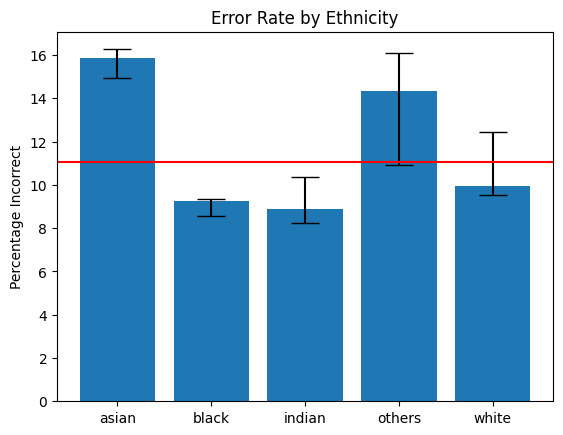

In [ ]:
from matplotlib import pyplot as plt

stats = aggregate_error_by_column('ethnicity')

plt.bar(stats.index, stats['median'], yerr=[stats['median'] - stats['min'], stats['max'] - stats['median']], capsize=10)
plt.axhline(error_rate, color='red')
plt.ylabel('Percentage Incorrect')
plt.xticks(stats.index, stats.index)
plt.title('Error Rate by Ethnicity')
plt.show()

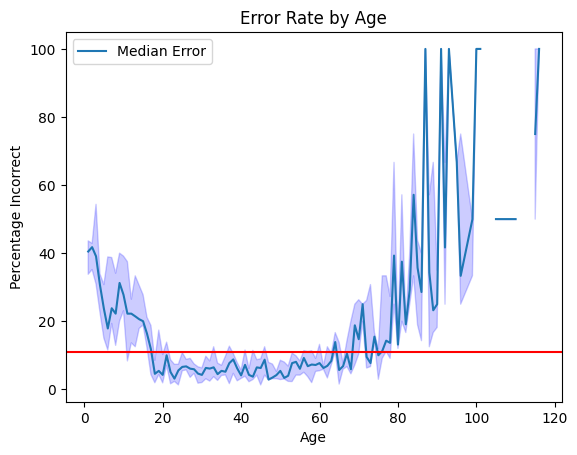

In [ ]:
from matplotlib import pyplot as plt

stats = aggregate_error_by_column('age')

plt.plot(stats.index, stats['median'], label='Median Error')
plt.fill_between(stats.index, stats['min'], stats['max'], color='blue', alpha=0.2)
plt.axhline(error_rate, color='red')

plt.ylabel('Percentage Incorrect')
plt.xlabel('Age')
plt.title('Error Rate by Age')

plt.legend()
plt.show()


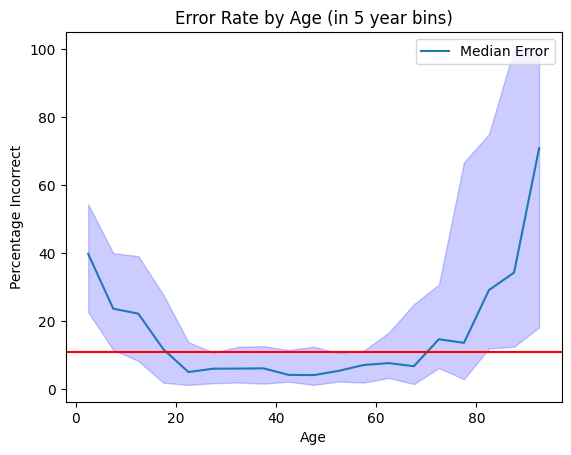

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

stats = aggregate_error_by_column('age')

age_bins = pd.cut(stats.index, bins=range(0, 100, 5), right=False)
binned_stats = stats.groupby(age_bins, observed=False).agg({'median': 'median', 'min': 'min', 'max': 'max'})

plt.plot(binned_stats.index.categories.mid, binned_stats['median'], label='Median Error')
plt.fill_between(binned_stats.index.categories.mid, binned_stats['min'], binned_stats['max'], color='blue', alpha=0.2)
plt.axhline(error_rate, color='red')

plt.ylabel('Percentage Incorrect')
plt.xlabel('Age')
plt.title('Error Rate by Age (in 5 year bins)')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to visualize attention
def plot_attention(image, attention):
  # Average attention weights across all heads
  attention = attention.cpu()
  attention = torch.mean(attention, dim=1)

  # Add diagonal matrix and re-normalize to account for residual attention
  residual = torch.eye(attention.size(1))
  attention_residual = attention + residual
  attention_residual = attention_residual / attention_residual.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.empty_like(attention_residual)
  joint_attentions[0] = attention_residual[0]

  for n in range(1, attention_residual.size(0)):
      joint_attentions[n] = attention_residual[n] @ joint_attentions[n-1]

  # Mapping output token to input space
  last_attention = joint_attentions[-1]
  grid_size = int(np.sqrt(torch.empty_like(attention_residual).size(-1)))
  attention_mask = last_attention[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  attention_maxk = attention_mask / attention_mask.max()
  attention_mask = cv2.resize(attention_mask, image.shape)[..., np.newaxis]

  # Plot results
  plt.title("Attention Visualization")
  plt.imshow(image.cpu(), cmap='gray')
  plt.imshow(attention_mask, alpha=0.6)
  plt.show()


In [ ]:
from vit_pytorch.vit import ViT

net = ViT(
    image_size = 48,
    patch_size = 8,
    num_classes = 1,
    dim = 256,
    depth = 6,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 1
).to(device)

model_state_dict = torch.load(f'./best_model.pth', map_location=torch.device(device))
net.load_state_dict(model_state_dict)

from vit_pytorch.recorder import Recorder
net = Recorder(net)

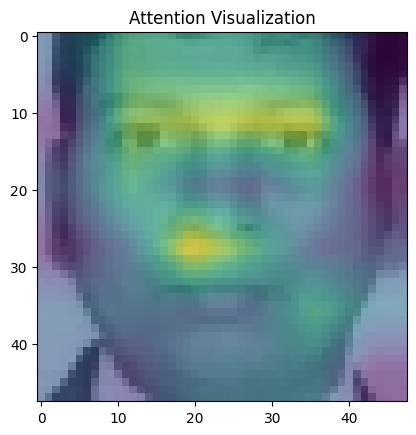

In [ ]:
images, labels = next(iter(testloader))
image = images[33, None]
prediction, attentions = net(image.to(device))

plot_attention(image[0, 0], attentions[0])